In [46]:
# load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import scatter_matrix

# stop warnings
import warnings 
warnings.filterwarnings('ignore')

In [47]:
# display column limita
pd.set_option('display.max_columns',500)

In [48]:
# load data
train = pd.read_csv('train.csv')
validation = pd.read_csv('test.csv')
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [49]:
# checking the balance of the data
print('The number of Non-Frauds are: ' + str(train['FraudResult'].value_counts()[0]) + ' which is', round(train['FraudResult'].value_counts()[0]/len(train) * 100,2), '% of the dataset')
print('The number of Frauds are: ' + str(train['FraudResult'].value_counts()[1]) + ' which is', round(train['FraudResult'].value_counts()[1]/len(train) * 100,2), '% of the dataset')

The number of Non-Frauds are: 95469 which is 99.8 % of the dataset
The number of Frauds are: 193 which is 0.2 % of the dataset


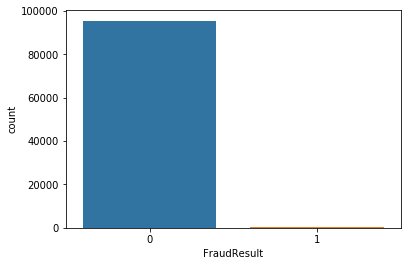

In [50]:
# visualize category class
sns.countplot(x='FraudResult', data=train)

the data is highly imbalanced, non frauds = 99.8% and frauds = 0.2%. It calls for smote balancing.

In [51]:
# SMOTE
# oversampling
from imblearn.over_sampling import SMOTE

count_class_0, count_class_1 = train.FraudResult.value_counts()

# divide by class
train_class_0 = train[train['FraudResult'] == 0]
train_class_1 = train[train['FraudResult'] == 1]

Random over-sampling:
1    95469
0    95469
Name: FraudResult, dtype: int64


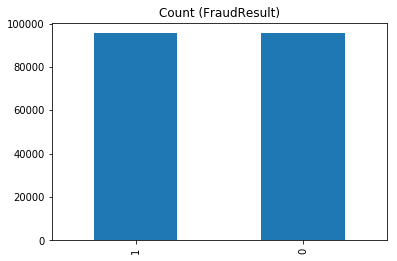

In [52]:
train_class_1_over = train_class_1.sample(count_class_0, replace=True)
train_test_over = pd.concat([train_class_0, train_class_1_over], axis=0)

print('Random over-sampling:')
print(train_test_over.FraudResult.value_counts())

train_test_over.FraudResult.value_counts().plot(kind='bar', title='Count (FraudResult)');

In [53]:
train1 = train_test_over 

In [54]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.columns

Index(['CountryCode', 'Amount', 'Value', 'PricingStrategy', 'FraudResult'], dtype='object')

In [55]:
categorical_features = train.select_dtypes(include=[np.object])
categorical_features.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'ProviderId', 'ProductId', 'ProductCategory',
       'ChannelId', 'TransactionStartTime'],
      dtype='object')

<function matplotlib.pyplot.show(*args, **kw)>

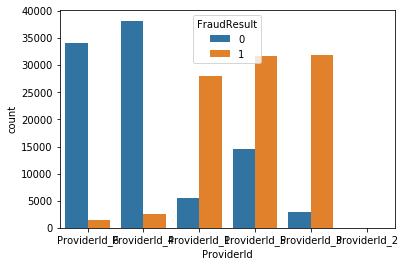

In [56]:
# pricing and fraudresults
sns.countplot(x='ProviderId', data=train1, hue='FraudResult')
plt.show

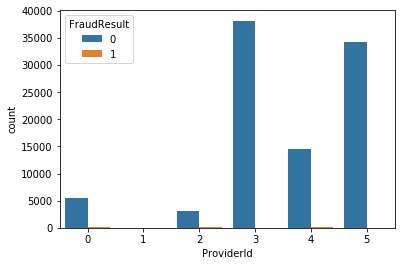

In [57]:
# encoding the provider column
# import labelencoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['ProviderId'] = le.fit_transform(train['ProviderId'])

sns.countplot(x='ProviderId', data=train, hue='FraudResult')

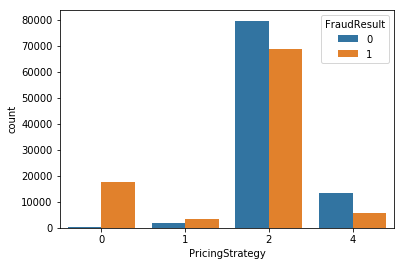

In [58]:
# pricingstrategy and fraudresult
sns.countplot(x='PricingStrategy', data=train1, hue='FraudResult')
plt.show()

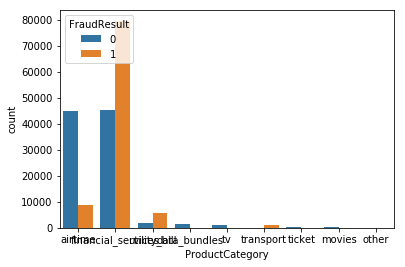

In [59]:
# product category and fraudresult
sns.countplot(x='ProductCategory',data = train1, hue = 'FraudResult')

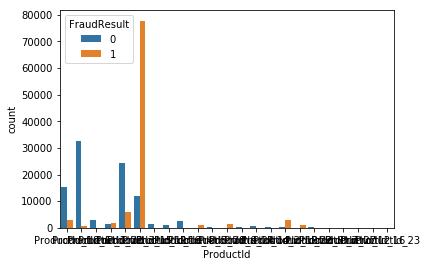

In [60]:
# ProductId and fraudresult
sns.countplot(x='ProductId', data = train1, hue = 'FraudResult')

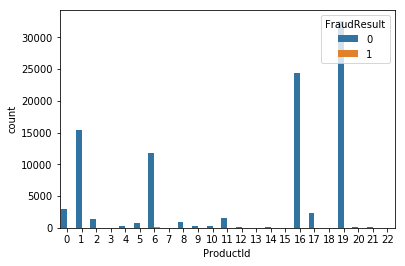

In [61]:
le = LabelEncoder()
train['ProductId'] = le.fit_transform(train['ProductId'])

sns.countplot(x='ProductId', data=train, hue='FraudResult')

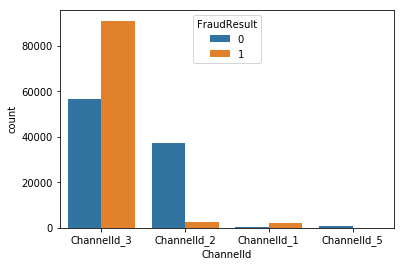

In [62]:
# channelid and fraudresult
sns.countplot(x='ChannelId', data = train1, hue = 'FraudResult')

1. find the outliers outliers and remove them
2. wrangle the time feature and include it to the rest of the data
3. drop features that do not correlate to fraud.
4. dummie-encoding the right features

In [63]:
# TIME WRANGLING
# train1
train1['hour'] = pd.to_datetime(train1.TransactionStartTime).dt.hour
train1['minute'] = pd.to_datetime(train1.TransactionStartTime).dt.minute
train1['day'] = pd.to_datetime(train1.TransactionStartTime).dt.dayofweek

# validation
validation['hour'] = pd.to_datetime(validation.TransactionStartTime).dt.hour
validation['minute'] = pd.to_datetime(validation.TransactionStartTime).dt.minute
validation['day'] = pd.to_datetime(validation.TransactionStartTime).dt.dayofweek


In [64]:
train1['period'] = np.nan
validation['period'] = np.nan

In [65]:
# train1
train1.loc[train1.hour < 7, 'period']= 'em'
train1.loc[(train1.hour >= 7) & (train1.hour < 11), 'period'] = 'am'
train1.loc[(train1.hour >= 11) & (train1.hour < 15), 'period'] = 'mid'
train1.loc[(train1.hour >= 15) & (train1.hour < 19), 'period'] = 'eve'
train1.loc[(train1.hour >= 19) & (train1.hour <=24), 'period'] = 'pm'

# validation
validation.loc[validation.hour < 7, 'period']= 'em'
validation.loc[(validation.hour >= 7) & (validation.hour < 11), 'period'] = 'am'
validation.loc[(validation.hour >= 11) & (validation.hour < 15), 'period'] = 'mid'
validation.loc[(validation.hour >= 15) & (validation.hour < 19), 'period'] = 'eve'
validation.loc[(validation.hour >= 19) & (validation.hour <=24), 'period'] = 'pm'

In [66]:
train1['minutes'] = train1['hour']*60 + train1['minute'] + train1['day']*24*60
validation['minutes'] = validation['hour']*60 + validation['minute'] + validation['day']*24*60
train1.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,hour,minute,day,period,minutes
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0,2,18,3,em,4458
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0,2,19,3,em,4459
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0,2,44,3,em,4484
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0,3,32,3,em,4532
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0,3,34,3,em,4534


In [67]:
# drop features
train1 = train1.drop(['BatchId','AccountId','SubscriptionId','CustomerId','CurrencyCode','CountryCode','Amount','TransactionStartTime','hour','minute','day'], axis=1)
validation = validation.drop(['BatchId','AccountId','SubscriptionId','CustomerId','CurrencyCode','CountryCode','Amount','TransactionStartTime','hour','minute','day'], axis=1)

In [68]:
# normalize
from sklearn.preprocessing import MinMaxScaler
# minutes
scaler_minutes = MinMaxScaler()
train1['minutes'] = train1['minutes'].astype('float64')
train1['minutes'] = scaler_minutes.fit_transform(train1.minutes.values.reshape(-1,1))

validation['minutes'] = scaler_minutes.fit_transform(validation.minutes.values.reshape(-1,1))
# value
scaler_Value = MinMaxScaler()
train1['Value'] = scaler_Value.fit_transform(train1.Value.values.reshape(-1,1))

validation['Value'] = scaler_Value.fit_transform(validation.Value.values.reshape(-1,1))

In [69]:
validation1 = validation.copy()

In [70]:
# drop Transactionid
train1 = train1.drop(['TransactionId'], axis=1)
validation = validation.drop(['TransactionId'], axis=1)
train1.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Value,PricingStrategy,FraudResult,period,minutes
0,ProviderId_6,ProductId_10,airtime,ChannelId_3,0.000101,2,0,em,0.442271
1,ProviderId_4,ProductId_6,financial_services,ChannelId_2,0.000002,2,0,em,0.442371
2,ProviderId_6,ProductId_1,airtime,ChannelId_3,0.000050,2,0,em,0.444853
3,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,0.002206,2,0,em,0.449618
4,ProviderId_4,ProductId_6,financial_services,ChannelId_2,0.000065,2,0,em,0.449816


In [71]:
# dummies
train1 = pd.get_dummies(train1, prefix_sep='_', drop_first=True)
validation = pd.get_dummies(validation, prefix_sep='_', drop_first=True)

In [72]:
# drop irrelevant features
train1 = train1.drop(['ProviderId_ProviderId_2','ProductId_ProductId_10','ProductId_ProductId_11','ProductId_ProductId_12','ProductId_ProductId_15','ProductId_ProductId_16','ProductId_ProductId_19','ProductId_ProductId_2','ProductId_ProductId_22','ProductId_ProductId_23','ProductId_ProductId_4','ProductId_ProductId_5','ProductId_ProductId_7','ProductId_ProductId_9','ProductCategory_data_bundles','ProductCategory_movies','ProductCategory_other','ProductCategory_ticket','ProductCategory_tv','ChannelId_ChannelId_5'], axis=1)
# drop irrelevant features
validation = validation.drop(['ProviderId_ProviderId_2','ProductId_ProductId_10','ProductId_ProductId_11','ProductId_ProductId_15','ProductId_ProductId_16','ProductId_ProductId_18','ProductId_ProductId_17','ProductId_ProductId_19','ProductId_ProductId_2','ProductId_ProductId_22','ProductId_ProductId_23','ProductId_ProductId_25','ProductId_ProductId_26','ProductId_ProductId_4','ProductId_ProductId_5','ProductId_ProductId_7','ProductId_ProductId_9','ProductCategory_data_bundles','ProductCategory_movies','ProductCategory_retail','ProductCategory_ticket','ProductCategory_tv','ChannelId_ChannelId_4','ChannelId_ChannelId_5'], axis=1)

In [73]:
# bring the fraudresult column to be 1st
FraudResult = train1['FraudResult']
train1.drop(['FraudResult'], axis=1, inplace=True)
train1.insert(0,'FraudResult', FraudResult)

In [74]:
# rename columns
train1.rename(columns={'ProviderId_ProviderId_3':'ProviderId3',
                       'ProviderId_ProviderId_4':'ProviderId4',
                       'ProviderId_ProviderId_5':'ProviderId5',
                       'ProviderId_ProviderId_6':'ProviderId6',
                       'ProductId_ProductId_13' :'ProductId13',
                       'ProductId_ProductId_14' :'ProductId14',
                       'ProductId_ProductId_20' :'ProductId20',
                       'ProductId_ProductId_21' :'ProductId21',
                       'ProductId_ProductId_24' :'ProductId24',
                       'ProductId_ProductId_27' :'ProductId27',
                       'ProductId_ProductId_3' :'ProductId3',
                       'ProductId_ProductId_6' :'ProductId6',
                       'ProductId_ProductId_8' :'ProductId8',
                       'ProductCategory_financial_services':'financial_services',
                       'ProductCategory_transport':'transport',
                       'ProductCategory_utility_bill':'utility_bill',
                       'ChannelId_ChannelId_2':'ChannelId2',
                       'ChannelId_ChannelId_3':'ChannelId3',
                       'period_em':'em',
                       'period_eve':'eve',
                       'period_mid':'mid',
                       'period_pm':'pm'}, inplace=True)

validation.rename(columns={'ProviderId_ProviderId_3':'ProviderId3',
                       'ProviderId_ProviderId_4':'ProviderId4',
                       'ProviderId_ProviderId_5':'ProviderId5',
                       'ProviderId_ProviderId_6':'ProviderId6',
                       'ProductId_ProductId_13' :'ProductId13',
                       'ProductId_ProductId_14' :'ProductId14',
                       'ProductId_ProductId_20' :'ProductId20',
                       'ProductId_ProductId_21' :'ProductId21',
                       'ProductId_ProductId_24' :'ProductId24',
                       'ProductId_ProductId_27' :'ProductId27',
                       'ProductId_ProductId_3' :'ProductId3',
                       'ProductId_ProductId_6' :'ProductId6',
                       'ProductId_ProductId_8' :'ProductId8',
                       'ProductCategory_financial_services':'financial_services',
                       'ProductCategory_transport':'transport',
                       'ProductCategory_utility_bill':'utility_bill',
                       'ChannelId_ChannelId_2':'ChannelId2',
                       'ChannelId_ChannelId_3':'ChannelId3',
                       'period_em':'em',
                       'period_eve':'eve',
                       'period_mid':'mid',
                       'period_pm':'pm'}, inplace=True)

In [75]:
train1.head()

,FraudResult,Value,PricingStrategy,minutes,ProviderId3,ProviderId4,ProviderId5,ProviderId6,ProductId13,ProductId14,ProductId20,ProductId21,ProductId24,ProductId27,ProductId3,ProductId6,ProductId8,financial_services,transport,utility_bill,ChannelId2,ChannelId3,em,eve,mid,pm
0,0,0.000101,2,0.442271,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,0,0.000002,2,0.442371,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0
2,0,0.000050,2,0.444853,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,0,0.002206,2,0.449618,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0
4,0,0.000065,2,0.449816,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0


In [76]:
train1['exponential'] = np.log(train1['Value']**2 + train1['PricingStrategy']**2 + train1['ProviderId3']**2 + train1['ProviderId4']**2 + train1['ProviderId6']**2 + train1['ProductId13']**2 +train1['ProductId14']**2 + train1['ProductId20']**2 + train1['ProductId21']**2 + train1['ProductId24']**2 + train1['ProductId27']**2 + train1['ProductId3']**2 + train1['ProductId6']**2 + train1['ProductId8']**2 + train1['financial_services']**2 + train1['transport']**2 + train1['utility_bill']**2 + train1['ChannelId2']**2 + train1['ChannelId3']**2)
train1['matrix'] = np.log(train1['ProviderId3']**2 + train1['ProviderId4']**2 + train1['ProviderId6']**2 + train1['Value']**2 + train1['ChannelId2']**2 + train1['ChannelId3']**2)
 
validation['exponential'] = np.log(validation['Value']**2 + validation['PricingStrategy']**2 + validation['ProviderId3']**2 + validation['ProviderId4']**2 + validation['ProviderId6']**2 + validation['ProductId13']**2 +validation['ProductId14']**2 + validation['ProductId20']**2 + validation['ProductId21']**2 + validation['ProductId24']**2 + validation['ProductId27']**2 + validation['ProductId3']**2 + validation['ProductId6']**2 + validation['ProductId8']**2 + validation['financial_services']**2 + validation['transport']**2 + validation['utility_bill']**2 + validation['ChannelId2']**2 + validation['ChannelId3']**2)
validation['matrix'] = np.log(validation['ProviderId3']**2 + validation['ProviderId4']**2 + validation['ProviderId6']**2 + validation['Value']**2 + validation['ChannelId2']**2 + validation['ChannelId3']**2)
     

In [77]:
train1.head()

,FraudResult,Value,PricingStrategy,minutes,ProviderId3,ProviderId4,ProviderId5,ProviderId6,ProductId13,ProductId14,ProductId20,ProductId21,ProductId24,ProductId27,ProductId3,ProductId6,ProductId8,financial_services,transport,utility_bill,ChannelId2,ChannelId3,em,eve,mid,pm,exponential,matrix
0,0,0.000101,2,0.442271,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1.791759,0.693147
1,0,0.000002,2,0.442371,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,2.079442,0.693147
2,0,0.000050,2,0.444853,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1.791759,0.693147
3,0,0.002206,2,0.449618,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1.945911,0.000005
4,0,0.000065,2,0.449816,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,2.079442,0.693147


In [78]:
scaler_exponential = MinMaxScaler()
train1['exponential'] = train1['exponential'].astype('float64')
train1['exponential'] = scaler_exponential.fit_transform(train1.exponential.values.reshape(-1,1))

# selection of features
y = train1.FraudResult
X = train1.drop(['FraudResult'], axis=1)

In [79]:
# cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
X = train1.drop(['FraudResult'], axis=1)

In [80]:
# simple models
# logistic regression
from sklearn.linear_model import LogisticRegression
for train_index, test_index in kf.split(X):
    LR = LogisticRegression(C=1.0, penalty='l2', tol=0.0001)
    X_train, X_test = X[train_index], X[test_index]
    y_train, t_test = y[train_index], y[test_index]
    LR = LR.fit(X_train, y_train)
    

    from sklearn.metrics import accuracy_score, f1_score
    LR = f1_score(y_test,y_pred)

KeyError: "None of [Int64Index([ 19094,  19095,  19096,  19097,  19098,  19099,  19100,  19101,\n             19102,  19103,\n            ...\n            190928, 190929, 190930, 190931, 190932, 190933, 190934, 190935,\n            190936, 190937],\n           dtype='int64', length=171844)] are in the [columns]"

In [43]:
# knn
from sklearn.neighbors import KNeighborsClassifier
for train_index, test_index in kf.split(X):
    knn = KNeighborsClassifier()
    X_train, X_test = X[train_index], X[test_index]
    y_train, t_test = y[train_index], y[test_index]
    
    knn = knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)

knn = f1_score(y_test,y_pred)

KeyError: "None of [Int64Index([ 19094,  19095,  19096,  19097,  19098,  19099,  19100,  19101,\n             19102,  19103,\n            ...\n            190928, 190929, 190930, 190931, 190932, 190933, 190934, 190935,\n            190936, 190937],\n           dtype='int64', length=171844)] are in the [columns]"

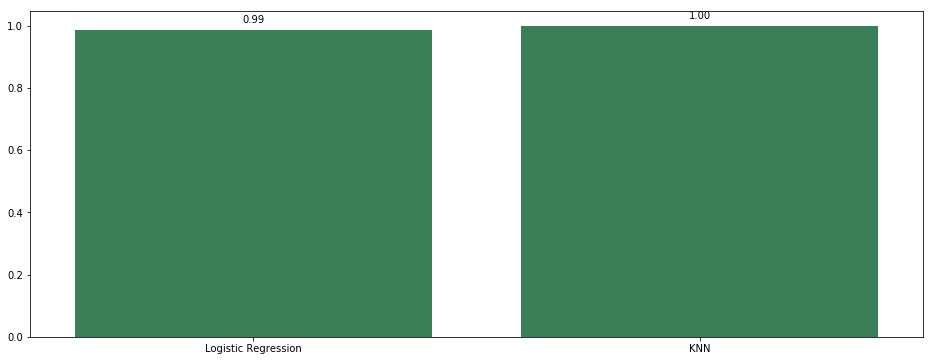

In [128]:
plt.figure(figsize=(16, 6))
s = sns.barplot(x=["Logistic Regression","KNN"], y=[LR,knn],color="seagreen")
for p in s.patches:
    s.annotate(format(p.get_height(), '.2f'), 
              (p.get_x() + p.get_width() / 2., 

               p.get_height()), ha = 'center', va = 'center', 
              xytext = (0, 10), textcoords = 'offset points')

In [129]:
# random forest
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
RFC = RFC.fit(X_train,y_train)
y_pred = RFC.predict(X_test)

RFC = f1_score(y_test,y_pred)

In [130]:
# Ada boost
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(n_estimators=100)
adb = adb.fit(X_train,y_train)
y_pred = adb.predict(X_test)

adb = f1_score(y_test,y_pred)

In [131]:
# gradient 
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier()
GBC = GBC.fit(X_train,y_train)
y_pred = GBC.predict(X_test)

GBC = f1_score(y_test,y_pred)

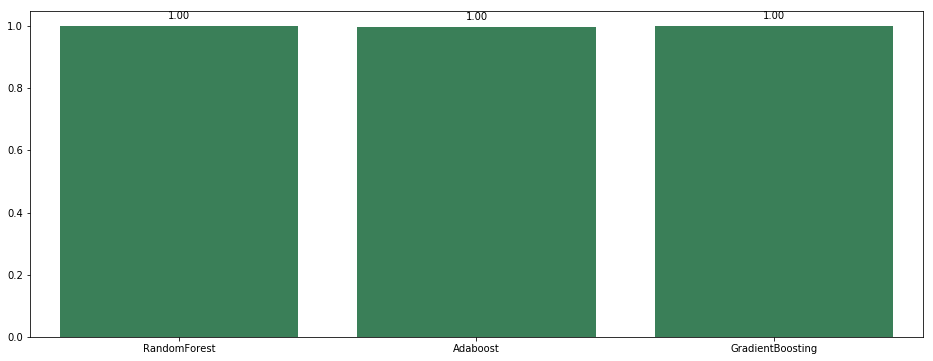

In [132]:
plt.figure(figsize=(16, 6))
s = sns.barplot(x=["RandomForest","Adaboost","GradientBoosting"], y=[RFC,adb,GBC],color="seagreen")
for p in s.patches:
    s.annotate(format(p.get_height(), '.2f'), 
              (p.get_x() + p.get_width() / 2., 

               p.get_height()), ha = 'center', va = 'center', 
              xytext = (0, 10), textcoords = 'offset points')

In [133]:
# bring the test dataset
# random forest
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
RFC = RFC.fit(X_train,y_train)


submit = RFC.predict(validation)

In [134]:
submission = pd.DataFrame({'TransactionId':validation1['TransactionId'],'FraudResult':submit})

In [135]:
submission.to_csv('submit8.csv', index=False)

SCORED 62.32% 